## Project: Banknote authentication
### Passive and Active Learning

### Perform:

1. Passive Learning
2. Active Learning

to classify bank notes

## Importing necessary packages

In [657]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import sklearn.metrics as metrics

import warnings # Package to ignore warnings
warnings.filterwarnings('ignore')

import random
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle

## UDFs

In [2]:
def fn_test_train_split(test_size=0.2):

    '''Test size is the only parameter needed to pass into the function with default 0.2
    This function splits the breast cancer dataset into test-train and returns 4 outputs:
        a. X Train
        b. X Test
        c. y Train
        d. y Test
    '''
    
    X_train, X_test, y_train, y_test = train_test_split(cancer_data.drop(['id','class'], axis=1), 
                                                    cancer_data[['class']],
                                                    test_size=0.2,
                                                    stratify=cancer_data['class']
                                                   )
    return(X_train, X_test, y_train, y_test)

In [386]:
def fn_roc_auc(FPR, TPR):
    
    '''Function to create ROC curve - Inputs are FPR, TPR'''
    
    plt.plot(FPR, TPR)
    plt.plot([0,1],[0,1])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    
    plt.show()

## Active & Passive learning using SVM

### a) Downloading the dataset from: 
https://archive.ics.uci.edu/ml/datasets/banknote+authentication

In [989]:
banknote_df = pd.read_csv('../data/data_banknote_authentication.csv', header=None)

In [990]:
# Since column names are not available, using the ones mentioned in the attribute information section of the data source
col_names  = ['variance','skewness','curtosis','entropy','class']

In [991]:
banknote_df.columns = col_names

In [992]:
banknote_df.head(2)

,variance,skewness,curtosis,entropy,class
0,3.6216,8.6661,-2.8073,-0.44699,0
1,4.5459,8.1674,-2.4586,-1.46210,0


In [993]:
banknote_df.shape

(1372, 5)

In [994]:
# Randomizing the rows
banknote_df = shuffle(banknote_df)

#### Normalizing the data

In [995]:
# Splitting data into train-test parts randomly with train size as 472
X_train, X_test, y_train, y_test = train_test_split(banknote_df.drop(['class'], axis=1), 
                                                    banknote_df[['class']],
                                                    test_size=472
                                                   )

# Normalizing the data
standarization = StandardScaler()

# Train data
train_std = standarization.fit(X_train)
X_train_trf = train_std.transform(X_train)

# Test data
test_std = standarization.fit(X_test)
X_test_trf = train_std.transform(X_test)

In [1000]:
print(X_train_trf.shape)
print(X_test_trf.shape)

(900, 4)
(472, 4)


### b) Train SVMs

#### i) Passive Learning

In [1046]:
def svc_ideal_parameters(traindata_X,traindata_y):

    '''This function helps to obtain the macximum and minimum range parameter values namely c & gamma in the 
    support vector cassifier to achieve an accuracy of atleast 70% 
    Input parameters:
        1. X train dataset
        2. y train dataset
    '''
    
    logspace = np.logspace(-5,8,14)
    c_list = []

    for log in logspace:
        model_svm = SVC(C = log)
        model_svm.fit(X_train,y_train)
        y_pred = model_svm.predict(X_train)

        if metrics.accuracy_score(y_pred,y_train) >= 0.7: # Filtering for parameters resulting in accuracy of atleast 0.7
            c_list.append(log)
    
    return(round(min(c_list),3),round(max(c_list),3))

In [1047]:
svc_ideal_parameters(X_train_trf,y_train)

(0.01, 100000000.0)

In [1048]:
X_train_trf_df = pd.DataFrame(X_train_trf)

In [1054]:
error_passive = []

for num in range(0,50):
    
    X_rolling_df = pd.DataFrame(columns=range(4))
    y_rolling_df = pd.DataFrame(columns=range(1))

    X_rolling_df.columns = list(X_train.columns)
    y_rolling_df.columns = list(y_train.columns)
    
    error_ls = []
    for i in range(0,90):
        # Model
        m_svm_passive = LinearSVC(penalty='l1',dual=False)
        m_svm_passive = GridSearchCV(estimator=m_svm_passive, param_grid={'C': np.logspace(-2,6,8)}, cv=5)

        X_random10_df = X_train_trf_df[10*i:10*(i+1)]
        X_random10_df.columns = list(X_train.columns)

        y_random10_df = y_train[10*i:10*(i+1)]
        y_random10_df.columns = list(y_train.columns)

        X_rolling_df = pd.concat([X_rolling_df,X_random10_df])

        y_rolling_df = pd.concat([y_rolling_df,y_random10_df])
        y_rolling_df=y_rolling_df.astype('int')

        m_svm_passive.fit(X_rolling_df.values, y_rolling_df.values)
        y_pred = m_svm_passive.predict(X_test_trf)

        error_ls.append(1- metrics.accuracy_score(y_pred, y_test))

    error_passive.append(error_ls)

#### ii) Active Learning

In [1055]:
error_active = []

for num in range(0,50):
    y_train_new = y_train.copy()
    X_train_trf_df_new = X_train_trf_df.copy()
    y_train_new = y_train_new.reset_index(drop=True)

    X_rolling_df = pd.DataFrame(columns=range(4))
    y_rolling_df = pd.DataFrame(columns=range(1))

    X_rolling_df.columns = list(X_train.columns)
    y_rolling_df.columns = list(y_train.columns)

    # Model
    error_ls = []

    m_svm_passive = LinearSVC(penalty='l1',dual=False)
    m_svm_passive = GridSearchCV(estimator=m_svm_passive, param_grid={'C': np.logspace(-2,6,8)}, cv=5)

    X_rolling_df = X_train_trf_df_new[0:10]
    X_rolling_df.columns = list(X_train.columns)

    y_rolling_df = y_train[0:10]
    y_rolling_df.columns = list(y_train.columns)
    y_rolling_df = y_rolling_df.astype('int')

    m_svm_passive.fit(X_rolling_df.values, y_rolling_df.values)
    y_pred = m_svm_passive.predict(X_test_trf)
    error_ls.append(1- metrics.accuracy_score(y_pred, y_test))

    closest10 = list(range(0,10))
    
    for i in range(1,90):

        # Adding closest 10
        df_X_closest10 = X_train_trf_df_new.filter(items= closest10, axis=0)
        df_y_closest10 = y_train_new.filter(items= closest10, axis=0)
        df_X_closest10.columns = list(X_train.columns)
        df_y_closest10.columns = list(y_train.columns)

        X_rolling_df = pd.concat([X_rolling_df,df_X_closest10])
        y_rolling_df = pd.concat([y_rolling_df,df_y_closest10])
        y_rolling_df = y_rolling_df.astype('int')

        # Dropping closest 10
        X_train_trf_df_new = X_train_trf_df_new.drop(index=closest10, axis=0)
        y_train_new = y_train_new.drop(index=closest10, axis=0)

        X_train_trf_df_new.reset_index(inplace=True, drop=True)
        y_train_new.reset_index(inplace=True, drop=True)

        # Model
        m_svm_passive = LinearSVC(penalty='l1',dual=False)
        m_svm_passive = GridSearchCV(estimator=m_svm_passive, param_grid={'C': np.logspace(-2,6,8)}, cv=5)

        m_svm_passive.fit(X_rolling_df.values, y_rolling_df.values)
        y_pred = m_svm_passive.predict(X_test_trf)

        dist_active = pd.DataFrame(m_svm_passive.decision_function(X_train_trf_df_new))
        dist_active_sorted = dist_active.sort_values(by=0)
        closest10 = list(dist_active_sorted[0:10].index)

        error_ls.append(1- metrics.accuracy_score(y_pred, y_test))
    error_active.append(error_ls)

### c) Comparison b/w Active and Passive learning

In [1056]:
temp_passive = pd.DataFrame(error_passive).mean()
temp_active = pd.DataFrame(error_active).mean()

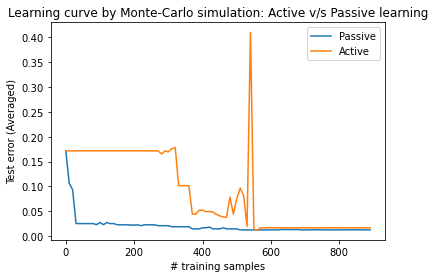

In [1057]:
plt.plot(list(range(0,900,10)),temp_passive,label="Passive")
plt.plot(list(range(0,900,10)),temp_active,label="Active")

plt.title('Learning curve by Monte-Carlo simulation: Active v/s Passive learning')
plt.xlabel('# training samples')
plt.ylabel('Test error (Averaged)')
plt.legend()

plt.show()

## Sources 

1. https://stackoverflow.com/questions/34842405/parameter-stratify-from-method-train-test-split-scikit-learn
2. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
3. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
4. https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
5. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
6. https://datatofish.com/filter-pandas-dataframe/
7. https://pandas.pydata.org/docs/reference/api/pandas.Series.append.html
8. https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
9. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
10. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.euclidean_distances.html
11. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html
12. https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
13. https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
